Original shape: (2154048, 19)
Inactive churners dropped: 299279
Shape after cleaning: (1854769, 19)
Shape after dropping useless columns: (1854769, 16)
[TOP_PACK] Number of rare packs (< 50) merged into 'RARE_PACK': 58

[PACK_GROUP] Distribution BEFORE merging rare groups:
PACK_GROUP
NO_PACK         603324
VOICE_ALLNET    384957
DATA_PACK       360442
VOICE_ONNET     321942
COMBO_PACK       67512
SOCIAL_PACK      66874
DAILY_PACK       45228
OTHER_PACK        3115
WIFI_PACK          651
RARE_PACK          432
EVC_PACK           139
WEEKLY_PACK         85
MONTHLY_PACK        68
Name: count, dtype: int64

[PACK_GROUP] Rare groups merged into 'OTHER_PACK': []

[PACK_GROUP] Final distribution:
PACK_GROUP
NO_PACK         603324
VOICE_ALLNET    384957
DATA_PACK       360442
VOICE_ONNET     321942
COMBO_PACK       67512
SOCIAL_PACK      66874
DAILY_PACK       45228
OTHER_PACK        3115
WIFI_PACK          651
RARE_PACK          432
EVC_PACK           139
WEEKLY_PACK         85
MONTHLY_PACK  

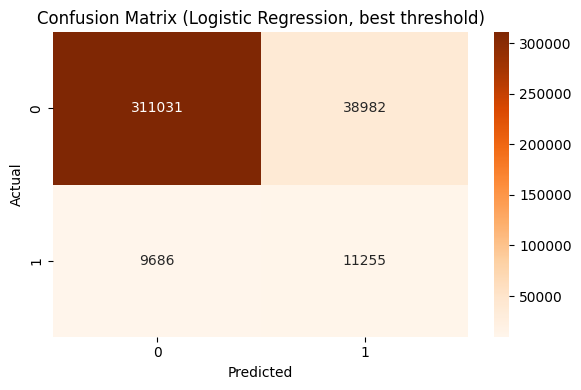

ROC-AUC (Logistic): 0.859670511412017


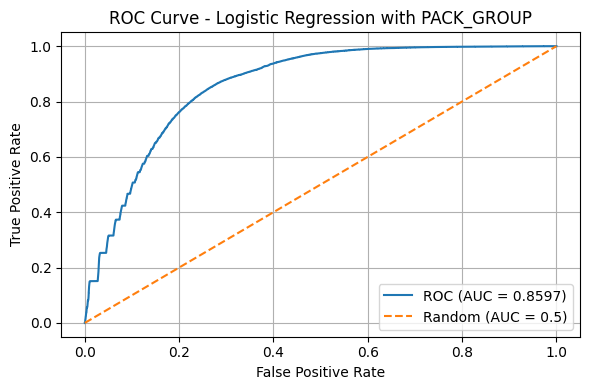


=========== LOGISTIC REGRESSION COEFFICIENTS (|coef| desc) ===========
           feature   coef  abs_coef
10      REGULARITY -1.351     1.351
12      REGION_enc  1.130     1.130
3        FREQUENCE  0.582     0.582
1   FREQUENCE_RECH -0.355     0.355
4      DATA_VOLUME  0.173     0.173
14  PACK_GROUP_enc -0.167     0.167
2          REVENUE  0.150     0.150
11   FREQ_TOP_PACK -0.115     0.115
0          MONTANT  0.064     0.064
8            ZONE1  0.049     0.049
13      TENURE_enc -0.041     0.041
5           ON_NET -0.034     0.034
6           ORANGE -0.028     0.028
7             TIGO -0.020     0.020
9            ZONE2  0.019     0.019


In [1]:
# =============================================================================
# 0. IMPORT
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
from sklearn.linear_model import LogisticRegression

# Make float output easier to read
pd.set_option('display.float_format', '{:.3f}'.format)


# =============================================================================
# 1. FUNCTION: CLEAN & STANDARDIZE TOP_PACK → TOP_PACK_CLEAN + PACK_GROUP
# =============================================================================
def prepare_top_pack(
    df,
    col_name="TOP_PACK",
    rare_threshold=50,
    new_clean_col="TOP_PACK_CLEAN",
    new_group_col="PACK_GROUP"
):
    """
    Clean and standardize the TOP_PACK column for churn modeling.

    Steps:
    1) Fill missing TOP_PACK with 'no_pack'
    2) Basic text cleaning (strip spaces)
    3) Merge rare packs (frequency < rare_threshold) into 'RARE_PACK'
    4) Map each cleaned pack name into a high-level group (PACK_GROUP)
    5) Merge very rare PACK_GROUPs into 'OTHER_PACK'

    Returns:
    - df with two new columns: new_clean_col and new_group_col
    """

    # 1. Fill missing values and clean basic string format
    df[col_name] = df[col_name].fillna("no_pack")
    top_pack_str = (
        df[col_name]
        .astype(str)      # ensure string type
        .str.strip()      # remove spaces at both ends
    )

    df[new_clean_col] = top_pack_str.copy()

    # 2. Rare handling for TOP_PACK (high-cardinality)
    pack_counts = df[new_clean_col].value_counts()
    rare_packs = pack_counts[pack_counts < rare_threshold].index

    df[new_clean_col] = df[new_clean_col].where(
        ~df[new_clean_col].isin(rare_packs),
        "RARE_PACK"
    )

    print(f"[TOP_PACK] Number of rare packs (< {rare_threshold}) merged into 'RARE_PACK': {len(rare_packs)}")

    # 3. Map cleaned pack names into PACK_GROUP
    def pack_group(x: str) -> str:
        s = str(x).lower()

        # No pack
        if s == "no_pack":
            return "NO_PACK"

        # Rare pack bucket
        if "rare_pack" in s:
            return "RARE_PACK"

        # Data / internet packs
        if ("data:" in s) or ("gprs" in s) or ("mifi" in s) or ("internet" in s):
            return "DATA_PACK"

        # WiFi / home internet
        if "wifi" in s:
            return "WIFI_PACK"

        # Voice on-net
        if "on net" in s or "on-net" in s or "onnet" in s:
            return "VOICE_ONNET"

        # Voice all-net (call to all operators)
        if "all-net" in s or "all net" in s or "allnet" in s:
            return "VOICE_ALLNET"

        # Combo / mixt packs (voice + data)
        if "mixt" in s or "mix " in s or "combo" in s:
            return "COMBO_PACK"

        # Social / youth packs (Facebook, Twitter, youth brands)
        if any(k in s for k in ["jokko", "ymgx", "youth", "facebook", "fb ", "twter", "twitter", "social"]):
            return "SOCIAL_PACK"

        # Daily packs
        if any(k in s for k in ["24h", "1day", "1 day", "daily", "one day"]):
            return "DAILY_PACK"

        # Weekly packs
        if "weekly" in s or "7d" in s or "7 d" in s or "week" in s:
            return "WEEKLY_PACK"

        # Monthly packs
        if any(k in s for k in ["monthly", "30d", "30 d", "month"]):
            return "MONTHLY_PACK"

        # EVC packs
        if "evc_" in s:
            return "EVC_PACK"

        # Sport packs (football, etc.)
        if "fifa" in s or "sport" in s:
            return "SPORT_PACK"

        # VAS / IVR / Radio / CRBT packs
        if any(k in s for k in ["vas(", "ivr", "radio", "crbt", "telmun"]):
            return "VAS_PACK"

        # Default bucket when nothing matches
        return "OTHER_PACK"

    df[new_group_col] = df[new_clean_col].apply(pack_group)

    print("\n[PACK_GROUP] Distribution BEFORE merging rare groups:")
    print(df[new_group_col].value_counts())

    # 4. Rare handling for PACK_GROUP (should be small already)
    group_counts = df[new_group_col].value_counts()
    rare_groups = group_counts[group_counts < 50].index.tolist()

    df[new_group_col] = df[new_group_col].where(
        ~df[new_group_col].isin(rare_groups),
        "OTHER_PACK"
    )

    print("\n[PACK_GROUP] Rare groups merged into 'OTHER_PACK':", rare_groups)
    print("\n[PACK_GROUP] Final distribution:")
    print(df[new_group_col].value_counts())

    return df


# =============================================================================
# 2. LOAD DATA
# =============================================================================
df = pd.read_csv("/kaggle/input/expresso-churn-prediction-challenge/Train.csv")   # change path if needed
print("Original shape:", df.shape)

# =============================================================================
# 3. CLEANING – DROP INACTIVE CHURN
# =============================================================================

# Usage-related columns (extend if needed)
usage_cols = [
    "MONTANT",
    "REVENUE",
    "ON_NET",
    "ORANGE",
    "TIGO",
    "ZONE1",
    "ZONE2"
]

# Replace missing with 0, then sum all usage columns
usage_sum = df[usage_cols].fillna(0).sum(axis=1)

# Mask for "inactive churners"
inactive_churn_mask = (usage_sum == 0) & (df["CHURN"] == 1)

print("Inactive churners dropped:", inactive_churn_mask.sum())

# Keep rows that are NOT inactive churners
df = df[~inactive_churn_mask].copy()
print("Shape after cleaning:", df.shape)

# =============================================================================
# 4. DROP USELESS COLUMNS (ID, derived, no information)
# =============================================================================
drop_cols = []
for col in ["ARPU_SEGMENT", "MRG", "user_id"]:
    if col in df.columns:
        drop_cols.append(col)

df = df.drop(columns=drop_cols)
print("Shape after dropping useless columns:", df.shape)

# =============================================================================
# 5. HANDLE MISSING VALUES
# =============================================================================

# Fill missing REGION
if "REGION" in df.columns:
    df["REGION"] = df["REGION"].fillna("unknown")

# Extra numeric columns related to usage
extra_numeric_cols = [
    "FREQUENCE_RECH",
    "FREQUENCE",
    "DATA_VOLUME",
    "FREQ_TOP_PACK"
]

# Fill numeric usage-like columns with 0
for col in usage_cols + extra_numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# =============================================================================
# 6. PREPARE TOP_PACK → TOP_PACK_CLEAN + PACK_GROUP
# =============================================================================
df = prepare_top_pack(
    df,
    col_name="TOP_PACK",
    rare_threshold=50,
    new_clean_col="TOP_PACK_CLEAN",
    new_group_col="PACK_GROUP"
)

# =============================================================================
# 7. CONVERT SAFE FLOAT COLUMNS TO INT (giữ nguyên xử lý của bạn)
# =============================================================================
def convert_float(df_):
    for col in df_.select_dtypes(include="float").columns:
        # if all non-missing values are whole numbers, convert to Int64
        if (df_[col].dropna() == np.floor(df_[col].dropna())).all():
            df_[col] = df_[col].astype("Int64")
    return df_

df = convert_float(df)

# =============================================================================
# 8. LABEL ENCODING FOR CATEGORICAL COLUMNS (REGION, TENURE, PACK_GROUP)
# =============================================================================
label_cols = []
for c in ["REGION", "TENURE", "PACK_GROUP"]:
    if c in df.columns:
        label_cols.append(c)

for col in label_cols:
    le = LabelEncoder()
    df[col + "_enc"] = le.fit_transform(df[col].astype(str))

# Drop raw string columns for modeling
df = df.drop(columns=label_cols + ["TOP_PACK", "TOP_PACK_CLEAN"])

print("\nDataFrame head after all cleaning + TOP_PACK grouping + encoding:")
print(df.head())

# =============================================================================
# 9. TRAIN / TEST SPLIT
# =============================================================================
# Drop rows where 'CHURN' is NaN before splitting
df_cleaned = df.dropna(subset=['CHURN'])

X = df_cleaned.drop("CHURN", axis=1)
y = df_cleaned["CHURN"]

print("\nFinal feature columns:", list(X.columns))
print("X shape:", X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTrain shape:", X_train.shape, " Test shape:", X_test.shape)
print("\nTrain target distribution:")
print(y_train.value_counts(normalize=True))

# =============================================================================
# 10. CHECK CLASS IMBALANCE (THAM KHẢO)
# =============================================================================
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
print("\n#NEG:", neg, " #POS:", pos, "  ratio NEG/POS =", neg / pos)

# =============================================================================
# 11. LOGISTIC REGRESSION + STANDARD SCALER (Pipeline)
# =============================================================================

# Logistic Regression khá nhạy với scale → dùng StandardScaler
logistic_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        max_iter=2000,
        class_weight="balanced"   # xử lý imbalance
    ))
])

print("\nTraining Logistic Regression + StandardScaler...")
logistic_pipeline.fit(X_train, y_train)
print("Training done.")

# =============================================================================
# 12. THRESHOLD OPTIMIZATION (maximize F1 for churn – class 1)
# =============================================================================
y_prob_lr = logistic_pipeline.predict_proba(X_test)[:, 1]

best_th_lr = 0.5
best_f1_lr = 0.0

# Scan many thresholds from 0.01 to 0.99
for t in np.linspace(0.01, 0.99, 300):
    y_pred_temp = (y_prob_lr >= t).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()

    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)

    if f1 > best_f1_lr:
        best_f1_lr = f1
        best_th_lr = t

print("\n===== BEST THRESHOLD (opt F1 for churn) – LOGISTIC REGRESSION =====")
print("Threshold:", best_th_lr)
print("Best F1 (churn):", best_f1_lr)

# =============================================================================
# 13. FINAL EVALUATION WITH BEST THRESHOLD
# =============================================================================
y_pred_lr = (y_prob_lr >= best_th_lr).astype(int)

print("\n=== FINAL CLASSIFICATION REPORT (Logistic Regression + PACK_GROUP) ===")
print(classification_report(y_test, y_pred_lr))

# Accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy_lr:.4f}")

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix (Logistic Regression, best threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC-AUC
auc_lr = roc_auc_score(y_test, y_prob_lr)
print("ROC-AUC (Logistic):", auc_lr)

# ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(6, 4))
plt.plot(fpr_lr, tpr_lr, label=f"ROC (AUC = {auc_lr:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression with PACK_GROUP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =============================================================================
# 14. "FEATURE IMPORTANCE" DẠNG COEFFICIENT CHO LOGISTIC REGRESSION
# =============================================================================
log_reg = logistic_pipeline.named_steps["log_reg"]
coefs = log_reg.coef_[0]

fi_lr = pd.DataFrame({
    "feature": X_train.columns,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

print("\n=========== LOGISTIC REGRESSION COEFFICIENTS (|coef| desc) ===========")
print(fi_lr)